In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# Loading images 2-B, 3-V, 4-R
fits_files = ['filter2.fits', 'filter3.fits', 'filter4.fits']
bvr_images = [fits.getdata(f'data/{f}') for f in fits_files]

In [3]:
# Plot settings 
plt.rc('font', size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

In [4]:
# Cutting the region we need from images
center_x, center_y = bvr_images[0].shape[1] // 2, bvr_images[0].shape[0] // 2

a, b = 2100, 1200
shift_x, shift_y = -100, -100
x1, x2 = center_x + shift_x - a // 2, center_x + shift_x  + a // 2
y1, y2 = center_y + shift_y  - b // 2, center_y + shift_y + b // 2

bvr_cut = [img[y1:y2, x1:x2] for img in bvr_images]

# Subtracting background 
x_min = 1600 
y_min = 200
width = 100  
height = 100 

x_max = x_min + width
y_max = y_min + height

bkg = np.zeros(3)
bkg[0] = np.median(bvr_cut[0][y_min:y_max, x_min:x_max])  
bkg[1] = np.median(bvr_cut[1][y_min:y_max, x_min:x_max])
bkg[2] = np.median(bvr_cut[2][y_min:y_max, x_min:x_max])

bvr_cut = [img - b for img, b in zip(bvr_cut, bkg)]

# Normalize images from 0 to 1
for i in range(3):
    bvr_cut[i] = (bvr_cut[i] - np.min(bvr_cut[i])) / (np.max(bvr_cut[i]) - np.min(bvr_cut[i]))

In [5]:
# Converting BVR to XYZ
xyz_images = np.zeros_like(bvr_cut)

xyz_images[0] = 0.19362 * bvr_cut[0] + 0.59315 * bvr_cut[1] + 0.31060 * bvr_cut[2]  # X
xyz_images[1] = 0.08265 * bvr_cut[0] + 1.10069 * bvr_cut[1] + 0.08009 * bvr_cut[2]  # Y
xyz_images[2] = 1.38826 * bvr_cut[0] - 0.11459 * bvr_cut[1] + 0.01970 * bvr_cut[2]  # Z

# Normalize images from 0 to 1
for i in range(3):
    xyz_images[i] = (xyz_images[i] - xyz_images[i].min()) / (xyz_images[i].max() - xyz_images[i].min())

# White spot correction
x_min = 1400 
y_min = 550   
width = 10    
height = 10   

x_max = x_min + width
y_max = y_min + height

white_spot_Y = np.median(xyz_images[1][y_min:y_max, x_min:x_max])

scale_X = 0.9505 / (xyz_images[0][y_min:y_max, x_min:x_max] / white_spot_Y).mean()
scale_Z = 1.0890 / (xyz_images[2][y_min:y_max, x_min:x_max] / white_spot_Y).mean()

xyz_images[0] = xyz_images[0] * scale_X
xyz_images[2] = xyz_images[2] * scale_Z

In [6]:
# Converting XYZ to RGB
rgb_images = np.zeros_like(xyz_images)

rgb_images[0] = 3.2410 * xyz_images[0] - 1.5374 * xyz_images[1] - 0.4986 * xyz_images[2]  # R
rgb_images[1] = -0.9692 * xyz_images[ 0] + 1.8760 * xyz_images[1] + 0.0416 * xyz_images[2]  # G
rgb_images[2] = 0.0556 * xyz_images[0] - 0.2040 * xyz_images[1] + 1.0570 * xyz_images[2]  # B

# Clipping values
rgb_images = np.clip(rgb_images, 0, 1)

# Gamma correction
srgb_images = np.where(rgb_images <= 0.0031308,
                          12.92 * rgb_images,
                          1.055 * (rgb_images ** (1 / 2.4)) - 0.055)


In [7]:
# Combine images
combined_bvr = np.stack([bvr_cut[0], bvr_cut[1], bvr_cut[2]], axis=-1)
combined_xyz = np.stack([xyz_images[0], xyz_images[1], xyz_images[2]], axis=-1)
combined_srgb = np.stack([srgb_images[0], srgb_images[1], srgb_images[2]], axis=-1)

# Inverting colors
# combined_bvr = 1 - combined_bvr
# combined_xyz = 1 - combined_xyz
# combined_srgb = 1 - combined_srgb

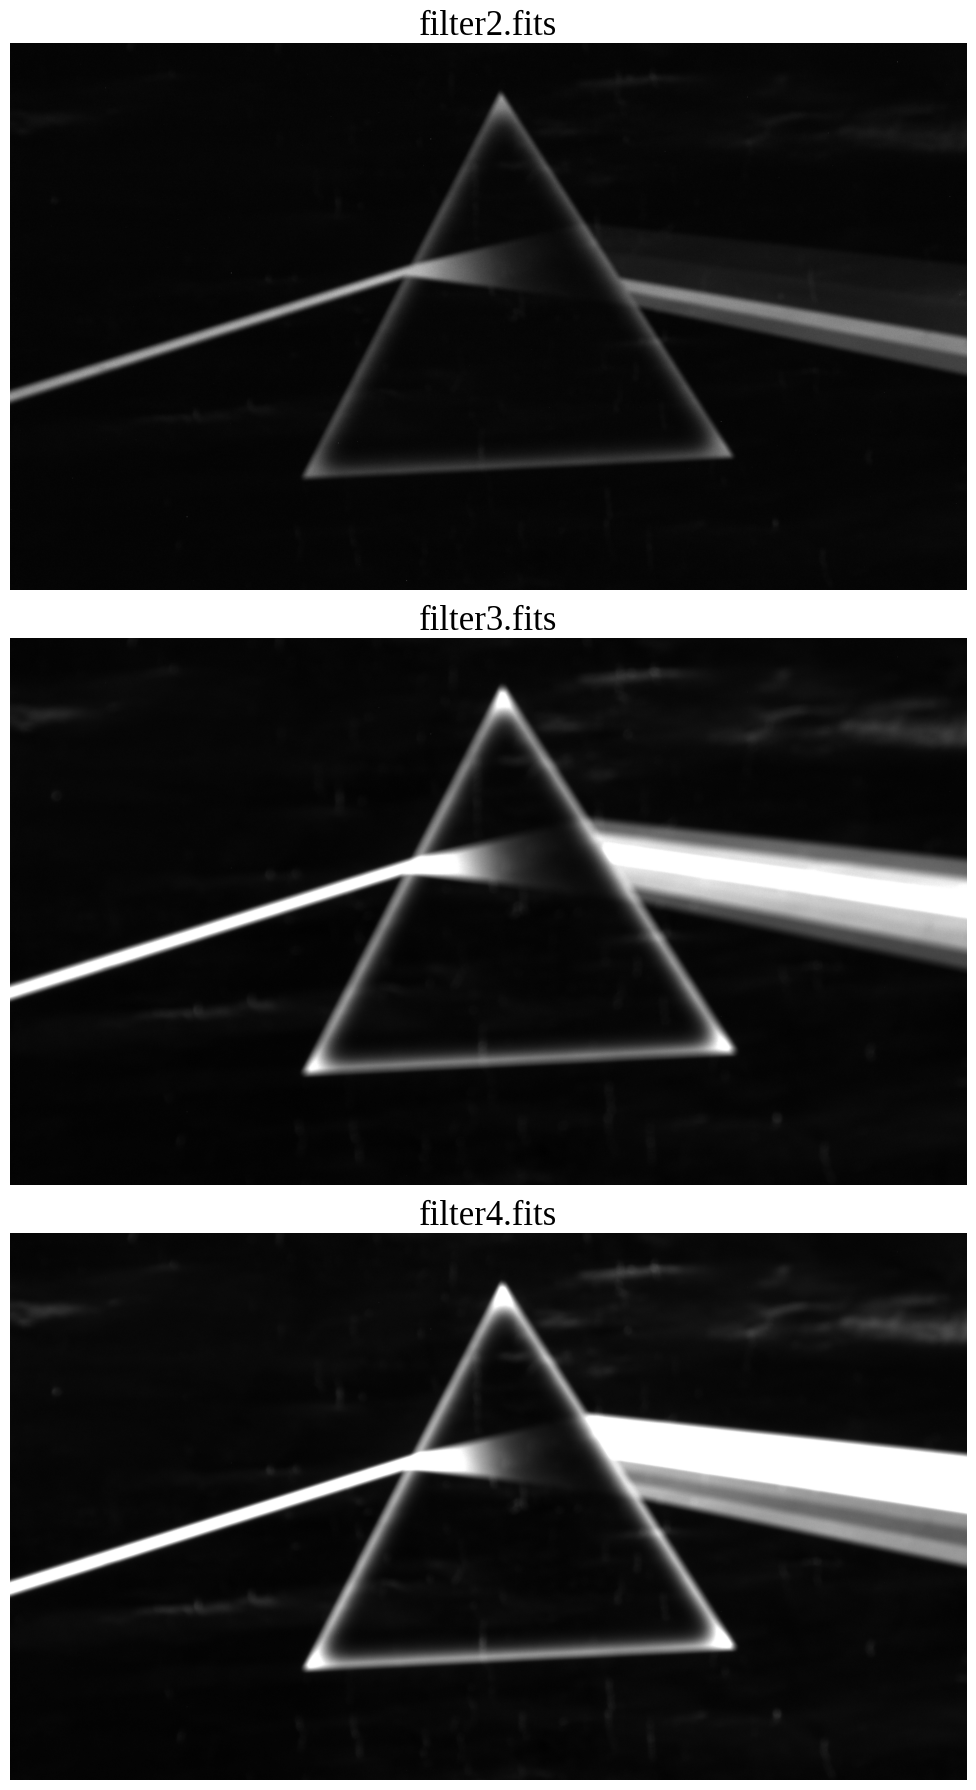

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10.5, 18))

vmin = 0
vmax = 0.5

for i, ax in enumerate(axes):
    ax.set_title(f'{fits_files[i]}', fontsize=25)
    
    ax.axis('off')
    
    ax.imshow(bvr_cut[i], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

    ax.set_ylim(ax.get_ylim()[::-1]) 
    ax.set_xlim(ax.get_xlim()[::-1])
    
plt.tight_layout()

plt.savefig('images/pf_ind.png')

plt.show()

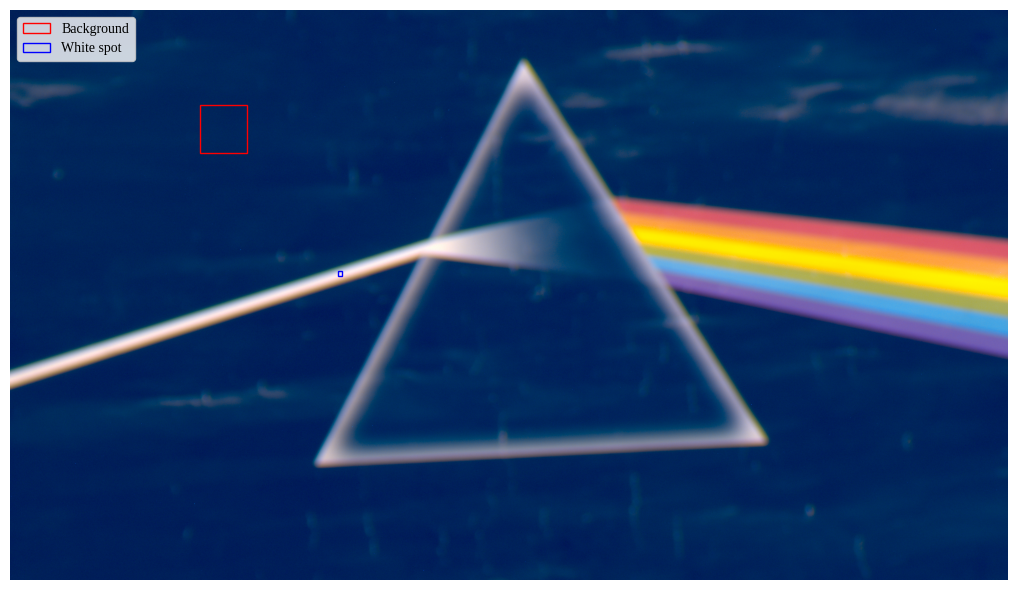

In [9]:
fig, ax = plt.subplots(figsize=(10.5, 6)) 

ax.axis('off')
plt.tight_layout()  

ax.imshow(combined_srgb, origin='lower')

rect = plt.Rectangle((1600, 200), 100, 100, linewidth=1, edgecolor='r', facecolor='none', label='Background')
ax.add_patch(rect)

rect = plt.Rectangle((1400, 550), 10, 10, linewidth=1, edgecolor='b', facecolor='none', label='White spot')
ax.add_patch(rect)

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.legend(loc='upper left')

plt.savefig('images/pf_srgb.png')

plt.show()

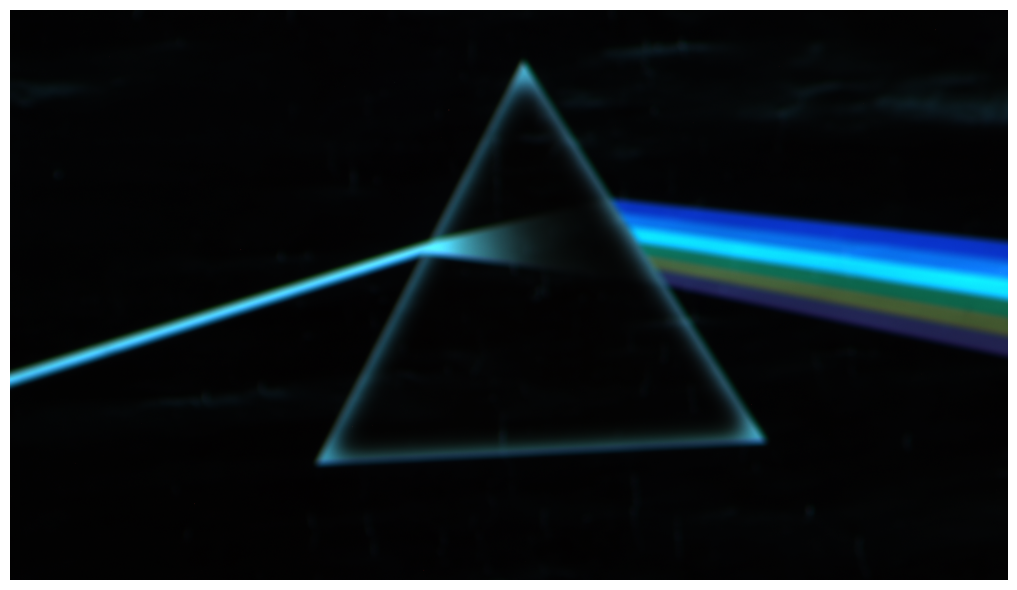

In [10]:
fig, ax = plt.subplots(figsize=(10.5, 6)) 

ax.axis('off')
plt.tight_layout()  

ax.imshow(combined_bvr, origin='lower')

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

plt.savefig('images/pf_bvr.png')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0251470868448203].


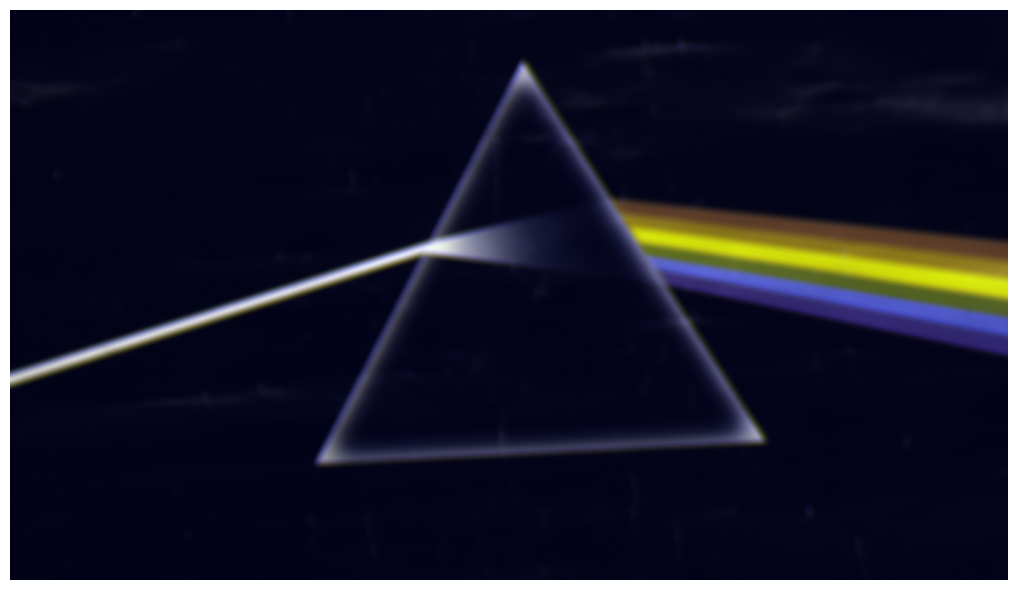

In [11]:
fig, ax = plt.subplots(figsize=(10.5, 6)) 

ax.axis('off')
plt.tight_layout()  

ax.imshow(combined_xyz, origin='lower')

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

plt.savefig('images/pf_xyz.png')

plt.show()